# 2026.01.05 DSM->訓練$\epsilon_{\theta}$
# 一維單峰

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cpu")

sigma_dsm=0.4
batch_size=2048


In [32]:
mu=5
sigma_data=1

def sample_x_unimodal(batch_size, x_dim, mu, sigma_data):
    mu_vec = np.array([mu] + [0]*(x_dim-1), dtype=np.float32)
    x = mu_vec + sigma_data* np.random.randn(batch_size, x_dim).astype(np.float32)
    return x


def sample_noisy_x_unimodal(batch_size, x_dim, sigma_dsm):
    x = sample_x_unimodal(batch_size, x_dim, mu, sigma_dsm)
    eps = np.random.randn(batch_size, x_dim).astype(np.float32)
    x_tilde = x + sigma_dsm * eps
    return x_tilde, eps


In [33]:
class ScoreNet(nn.Module):
    def __init__(self, x_dim, hidden, num_layers):
        super().__init__()

        layers = [nn.Linear(x_dim, hidden), nn.SiLU()]
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden, hidden))
            layers.append(nn.SiLU())
        layers.append(nn.Linear(hidden, x_dim)) 

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

model=ScoreNet(x_dim =1, hidden=64, num_layers=3).to(device)


def dsm_loss_step(x_dim, sampler):
    x_tilde_np, eps_np = sampler(batch_size, x_dim, sigma_dsm)
    x_tilde = torch.from_numpy(x_tilde_np).to(device)
    eps     = torch.from_numpy(eps_np).to(device)

    eps_pred = model(x_tilde)  ###<<<<< 預測epsilon

    target = eps
    loss = ((eps_pred - target)**2).mean()
    return loss



In [34]:
model=ScoreNet(x_dim =1, hidden=64, num_layers=3).to(device)

#### Training Loop
num_steps=5000
lr=5e-3

optimizer=optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,       
    patience=200,     
    verbose=True
)
loss_history = []

for step in range(1, num_steps+1):
    model.train()

    loss = dsm_loss_step(1, sample_noisy_x_unimodal)
    

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

 
    scheduler.step(loss)

    loss_history.append(loss.item())

    if step % 200 == 0:
        print(f"step {step:4d} | loss = {loss.item():.6f} | lr = {lr:.6f}")


step  200 | loss = 0.502296 | lr = 0.005000
step  400 | loss = 0.512800 | lr = 0.005000
step  600 | loss = 0.497166 | lr = 0.005000
step  800 | loss = 0.493400 | lr = 0.005000
step 1000 | loss = 0.511801 | lr = 0.005000
step 1200 | loss = 0.510644 | lr = 0.005000
step 1400 | loss = 0.490493 | lr = 0.005000
step 1600 | loss = 0.477848 | lr = 0.005000
step 1800 | loss = 0.516934 | lr = 0.005000
step 2000 | loss = 0.502158 | lr = 0.005000
step 2200 | loss = 0.510225 | lr = 0.005000
step 2400 | loss = 0.483423 | lr = 0.005000
step 2600 | loss = 0.506198 | lr = 0.005000
step 2800 | loss = 0.517553 | lr = 0.005000
step 3000 | loss = 0.525038 | lr = 0.005000
step 3200 | loss = 0.505945 | lr = 0.005000
step 3400 | loss = 0.492088 | lr = 0.005000
step 3600 | loss = 0.517169 | lr = 0.005000
step 3800 | loss = 0.515880 | lr = 0.005000
step 4000 | loss = 0.539616 | lr = 0.005000
step 4200 | loss = 0.495632 | lr = 0.005000
step 4400 | loss = 0.516850 | lr = 0.005000
step 4600 | loss = 0.487441 | lr

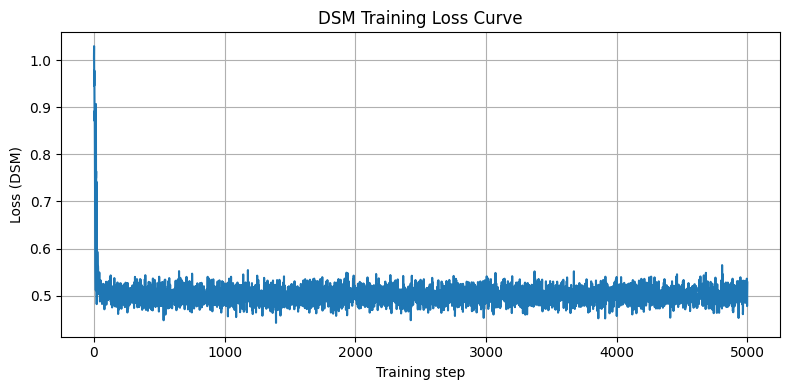

In [35]:
import matplotlib.pyplot as plt

def plot_loss_curve(loss_list):
    """
    loss_list: Python list or Tensor containing loss values for each step
    """
    plt.figure(figsize=(8,4))
    plt.plot(loss_list, linewidth=1.5)
    plt.xlabel("Training step")
    plt.ylabel("Loss (DSM)")
    plt.title("DSM Training Loss Curve")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_loss_curve(loss_history)

# 一維單峰 Sampling

In [36]:
steps = 2000
eta = 0.00005

x_dim = 1
sigma_noise = 0.4  
K_traj = 20 
N_total=5000

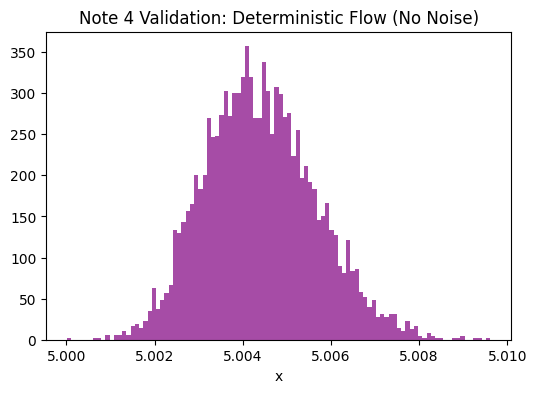

In [53]:
def langevin_sampling(model, steps, eta, x_dim, N_total, mu, sigma_final_denoise, deterministic):
    N=N_total
    model.eval()
    x = mu+torch.randn(N, x_dim).to(device) 
    sqrt_2eta = torch.sqrt(torch.tensor(2 * eta, device=device))

    with torch.no_grad():
        for k in range(steps):
            eps_pred = model(x)
            score = -eps_pred / sigma_final_denoise

            noise = torch.randn_like(x)

            if deterministic:
                # Note 4 模式：只跟著 Score 走 (ODE flow)
                x = x + eta * score 
            else:
                # 正常 Langevin 模式
                noise = torch.randn_like(x)
                x = x + eta * score + sqrt_2eta * noise        
        # 2. (新增) 最後一步去噪 (Tweedie's Formula)
        # 原因：Langevin 採樣出來的是 "含噪分佈" (x + sigma)。
        # 如果不加這一步，你的雙峰會看起來比較 "胖" (標準差比較大)。
        # 加了這一步，點會瞬間收束到分佈的中心 (Manifold)。
        if sigma_final_denoise > 0:
            final_eps = model(x)
            x = x - sigma_final_denoise * final_eps

    return x.detach().cpu().numpy()

# === 測試 Note 4 ===
# 開啟 deterministic=True，這時候所有點應該會收斂成 "一根針"
final_samples = langevin_sampling(
    model, steps=2000, eta=0.001, x_dim=1, 
    N_total=5000, mu=10, sigma_final_denoise=sigma_dsm, 
    deterministic=True # <--- 關鍵
)

plt.figure(figsize=(6, 4))
plt.hist(final_samples, bins=100, density=True, color='purple', alpha=0.7)
plt.title("Note 4 Validation: Deterministic Flow (No Noise)")
plt.xlabel("x")
plt.show()

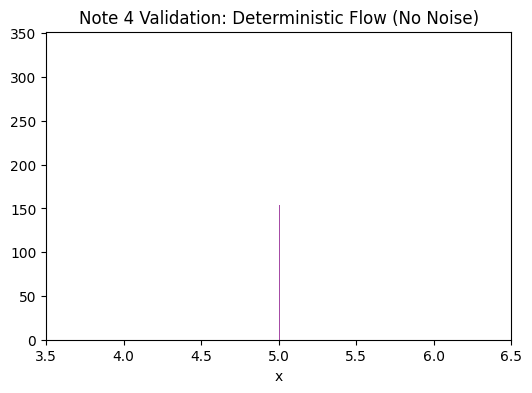

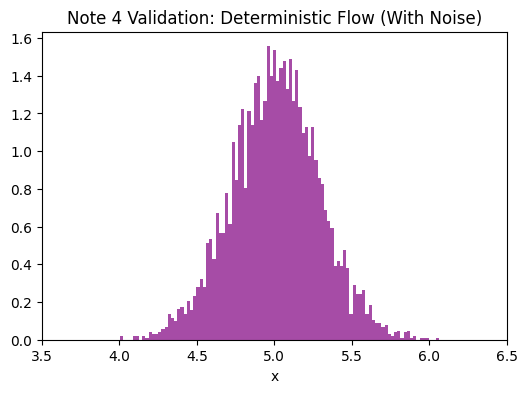

In [58]:

# 設定統一的 X 軸範圍 (根據你的第二張圖，大約 3.5 到 6.5 適合)
COMMON_X_LIMIT = (3.5, 6.5) 

# === 情況 1: Deterministic (無噪聲，你的 Note 4 驗證) ===
final_samples_det = langevin_sampling(
    model, steps=2000, eta=0.001, x_dim=1, 
    N_total=5000, mu=10, sigma_final_denoise=sigma_dsm, 
    deterministic=True 
)

plt.figure(figsize=(6, 4))
plt.hist(final_samples_det, bins=100, density=True, color='purple', alpha=0.7)
plt.title("Note 4 Validation: Deterministic Flow (No Noise)")
plt.xlim(COMMON_X_LIMIT)  # <--- 關鍵：鎖定範圍
plt.xlabel("x")
plt.show()

# === 情況 2: With Noise (正常 Langevin) ===
# 假設你跑了這一段來產生第二張圖
final_samples_noisy = langevin_sampling(
    model, steps=2000, eta=0.001, x_dim=1, 
    N_total=5000, mu=10, sigma_final_denoise=sigma_dsm, 
    deterministic=False  # <--- 有噪聲
)

plt.figure(figsize=(6, 4))
plt.hist(final_samples_noisy, bins=100, density=True, color='purple', alpha=0.7)
plt.title("Note 4 Validation: Deterministic Flow (With Noise)")
plt.xlim(COMMON_X_LIMIT)  # <--- 關鍵：使用跟上面一樣的範圍
plt.xlabel("x")
plt.show()

In [63]:
from matplotlib.gridspec import GridSpec

def langevin_trajectories(model, steps, eta, x_dim,
                          N_total, K_traj, mu, sigma_dsm):
    model.eval()

    x = mu+ torch.randn(N_total, x_dim, device=device)
    x_init_all = x.detach().cpu().numpy().copy()
    
    x_traj = x[:K_traj].clone()
    traj_hist = [x_traj.detach().cpu().numpy().copy()]   # shape (K_traj, x_dim)
    sqrt_2eta = torch.sqrt(torch.tensor(2*eta, device=device))
    
    for k in range(steps):
        with torch.no_grad():
            # 【修改點 1】模型預測雜訊 -> 轉回 Score
            eps_pred = model(x)
            score = -eps_pred / sigma_dsm  # Score = -eps / sigma
            
            # Langevin Update
            noise = torch.randn_like(x)
            x = x + eta * score #+ sqrt_2eta * noise

            # 紀錄
            x_traj = x[:K_traj]
            traj_hist.append(x_traj.detach().cpu().numpy().copy())
    """
    # 【修改點 2】(選用) 最後一步 Tweedie 去噪
    # 如果不加這一步，x_final_all 會是含噪分佈 (比較胖)
    # 加了這一步，x_final_all 會是去噪後的結果 (比較銳利，接近真實數據)
    if sigma_dsm > 0:
        with torch.no_grad():
            final_eps = model(x)
            x = x - sigma_dsm * final_eps  # x_0 = x_t - sigma * eps
            # 【新增】把去噪後的點也加進軌跡紀錄裡
            x_traj = x[:K_traj]
            traj_hist.append(x_traj.detach().cpu().numpy().copy())
    """
    x_final_all = x.detach().cpu().numpy().copy()
    traj_hist = np.stack(traj_hist, axis=0)   # shape: (steps+1, K_traj, x_dim)

    return x_init_all, x_final_all, traj_hist



def plot_3_figure(steps, eta):

    x_init_all, x_final_all, traj_hist = langevin_trajectories(
    model, steps=steps, eta=eta, x_dim=x_dim,
    N_total=5000, K_traj=20, mu=mu, sigma_dsm=sigma_dsm
)

    ####=====================
    fig = plt.figure(figsize=(12, 3))
    gs = GridSpec(1, 3, width_ratios=[1, 4, 1], wspace=0.3)

    ax_left  = fig.add_subplot(gs[0])
    ax_mid   = fig.add_subplot(gs[1])
    ax_right = fig.add_subplot(gs[2])

    # 左圖：初始分佈 (應該在 5 附近)
    ax_left.hist(x_init_all[:, 0], bins=40, density=True, orientation='horizontal', color='gray', alpha=0.6)
    ax_left.set_title("Initialization\n($x \\approx \mu$)")
    ax_left.set_xlabel("density")
    ax_left.set_ylim(-2, 12) # 設定範圍方便觀察爆炸與否

    # 中圖：軌跡 (應該要在 5 附近震盪)
    t_axis = np.arange(traj_hist.shape[0])
    for i in range(traj_hist.shape[1]):
        ax_mid.plot(t_axis, traj_hist[:, i, 0], alpha=0.6, linewidth=1)

    ax_mid.set_title(f"Langevin Trajectories\n(steps={steps}, eta={eta})")
    ax_mid.set_xlabel("Steps")
    ax_mid.set_ylabel("x")
    ax_mid.set_ylim(-2, 12) # 設定與左圖一樣的範圍

    # 右圖：最終分佈 (應該還是在 5 附近，且符合 Gaussian)
    ax_right.hist(x_final_all[:, 0], bins=40, density=True, orientation='horizontal', color='orange', alpha=0.7)
    ax_right.set_title("Generated Samples")
    ax_right.set_xlabel("density")
    ax_right.set_ylim(-2, 12)

    plt.tight_layout()
    plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_15100\64052433.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


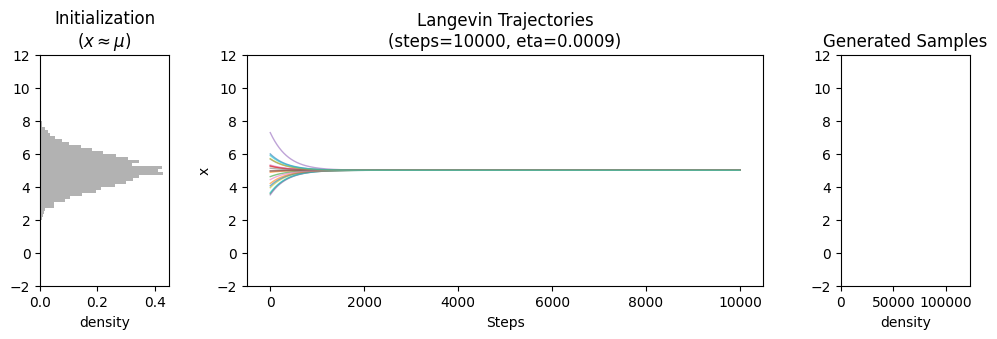

In [68]:
plot_3_figure(steps=10000, eta=9e-4)